## Notebook Purpose
- This notebook was used to check conservation of mass before and after application of adaptive Gaussian filter on flux divergence and expected slope-parallel elevation change in response to Reviewer's comment
- Last updated: November 27th, 2023


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from imview import pltlib
import pandas as pd
from pygeotools.lib import warplib,geolib,iolib,malib,filtlib,timelib
import os,sys,glob,shutil
from velocity_proc import glac_dyn, constants, velocity_filter,velocity_timeseries
import warnings
warnings.filterwarnings('ignore')

In [3]:
divq2_mean_list = []
smooth_divq2_mean_list = []
divq2_sum_list = []
smooth_divq2_sum_list = []
downslope_mean_list = []
smooth_downslope_mean_list = []
downslope_sum_list = []
smooth_downslope_sum_list = []

## Khubmbu

In [5]:
%cd /nobackup/sbhusha1/chapter2/changrinup/20230217/

/nobackupp11/sbhusha1/chapter2/changrinup/20230217


In [6]:
div_q2_smooth_fn = 'khumbu_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/khumbu_farinotti_2015-11-02_to_2016-10-25_divQ2.tif'
downslope_smooth_fn = 'khumbu_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/khumbu_farinotti_2015-11-02_to_2016-10-25_downslope_dhdt.tif'
dem1_fn = '../20151102_aligned.tif'
H_fn = constants.fetch_farinotti_thickness('khumbu')
vx_fn = '20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif'
vy_fn = '20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif'
ds_list = warplib.memwarp_multi_fn([div_q2_smooth_fn,H_fn,vx_fn,vy_fn,downslope_smooth_fn,dem1_fn])
div_q2_smooth,H,vx,vy,downslope_smooth,dem1 = [iolib.ds_getma(ds) for ds in ds_list]
glac_shp = gpd.read_file(constants.fetch_glac_shp(constants.rgi_dicts['khumbu'])).to_crs("EPSG:32645")


Warping all inputs to the following:
Resolution: 25.0
Extent: [481512.5, 3090517.0, 488435.0, 3099662.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 6: khumbu_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/khumbu_farinotti_2015-11-02_to_2016-10-25_divQ2.tif
nl: 366 ns: 277 res: 25.000
0...10...20...30...40...50...60...70...80...90...2 of 6: /nobackup/sbhusha1/hma/ngozumpa_lagdz/icethickness/RGI60-15/RGI60-15.03733_thickness.tif
nl: 366 ns: 277 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 6: 20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif
nl: 366 ns: 277 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 6: 20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/

In [7]:
res = geolib.get_res(ds_list[0])[0]
divq2 = glac_dyn.compute_simple_flux_div(vx,vy,H,dx=res,dy=res,smooth=False)
t1 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_farinotti_')[1].split('_to')[0])
t2 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_to_')[1].split('_divQ2')[0])
dt = timelib.get_t_factor(t1,t2)
downslope_dhdt = glac_dyn.compute_along_slope_flow_correction_working(dem1,vx,vy,dt=dt,smooth=False,origmask=True,res=res)

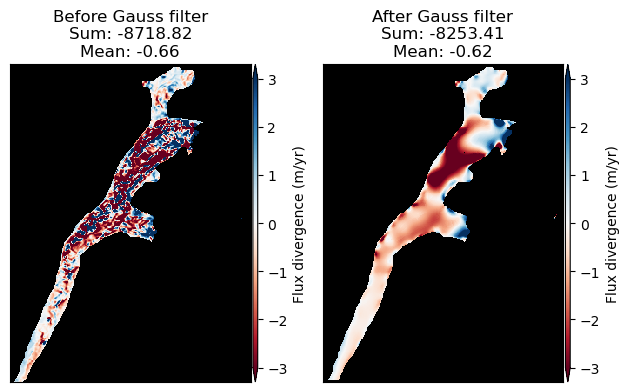

In [8]:
f,ax = plt.subplots(1,2)
mean_init = np.round(divq2.mean(),2)
mean_final = np.round(div_q2_smooth.mean(),2)
sum_init = np.round(divq2.sum(),2)
sum_final = np.round(div_q2_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(divq2,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='Flux divergence (m/yr)')
pltlib.iv(div_q2_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='Flux divergence (m/yr)')
divq2_mean_list.append(mean_init)
divq2_sum_list.append(sum_init)
smooth_divq2_mean_list.append(mean_final)
smooth_divq2_sum_list.append(sum_final)

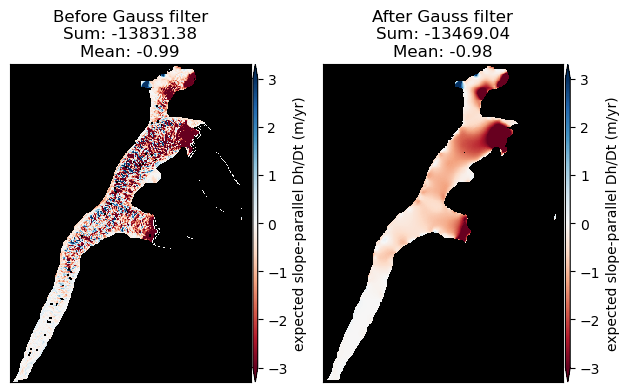

In [9]:
f,ax = plt.subplots(1,2)
downslope_dhdt = velocity_timeseries.mask_by_shp(glac_shp.geometry,downslope_dhdt,ds=ds_list[1])
mean_init = np.round(downslope_dhdt.mean(),2)
mean_final = np.round(downslope_smooth.mean(),2)
sum_init = np.round(downslope_dhdt.sum(),2)
sum_final = np.round(downslope_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(downslope_dhdt,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='expected slope-parallel Dh/Dt (m/yr)')
pltlib.iv(downslope_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='expected slope-parallel Dh/Dt (m/yr)')
downslope_mean_list.append(mean_init)
downslope_sum_list.append(sum_init)
smooth_downslope_mean_list.append(mean_final)
smooth_downslope_sum_list.append(sum_final)

## Changri Nup

In [10]:
div_q2_smooth_fn = 'black_changri_nup_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_2015-11-02_to_2016-10-25_divQ2.tif'
downslope_smooth_fn = 'black_changri_nup_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_2015-11-02_to_2016-10-25_downslope_dhdt.tif'
dem1_fn = '../20151102_aligned.tif'
H_fn = constants.fetch_farinotti_thickness('changri_nup')
vx_fn = '20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif'
vy_fn = '20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif'
ds_list = warplib.memwarp_multi_fn([div_q2_smooth_fn,H_fn,vx_fn,vy_fn,downslope_smooth_fn,dem1_fn])
div_q2_smooth,H,vx,vy,downslope_smooth,dem1 = [iolib.ds_getma(ds) for ds in ds_list]
glac_shp = gpd.read_file('/nobackup/sbhusha1/hma/agu22_scratch/Black_changri_with_accumulation_area2.shp')


Warping all inputs to the following:
Resolution: 25.0
Extent: [476612.5, 3094162.5, 482987.5, 3099437.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 6: black_changri_nup_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_2015-11-02_to_2016-10-25_divQ2.tif
2 of 6: /nobackup/sbhusha1/hma/ngozumpa_lagdz/icethickness/RGI60-15/RGI60-15.03734_thickness.tif
3 of 6: 20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif
nl: 211 ns: 255 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 6: 20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif
nl: 211 ns: 255 res: 25.000
10

In [11]:
res = geolib.get_res(ds_list[0])[0]
divq2 = velocity_timeseries.mask_by_shp(glac_shp.geometry,glac_dyn.compute_simple_flux_div(vx,vy,H,dx=res,dy=res,smooth=False),ds=ds_list[0])
t1 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('nup_')[1].split('_to')[0])
t2 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_to_')[1].split('_divQ2')[0])
dt = timelib.get_t_factor(t1,t2)
downslope_dhdt = velocity_timeseries.mask_by_shp(glac_shp.geometry,glac_dyn.compute_along_slope_flow_correction_working(dem1,vx,vy,dt=dt,smooth=False,origmask=True,res=res),ds=ds_list[0])

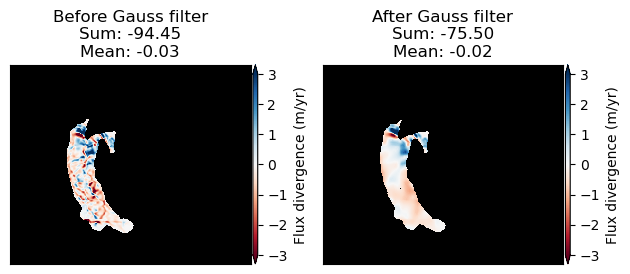

In [12]:
f,ax = plt.subplots(1,2)
mean_init = np.round(divq2.mean(),2)
mean_final = np.round(div_q2_smooth.mean(),2)
sum_init = np.round(divq2.sum(),2)
sum_final = np.round(div_q2_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(divq2,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='Flux divergence (m/yr)')
pltlib.iv(div_q2_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='Flux divergence (m/yr)')
divq2_mean_list.append(mean_init)
divq2_sum_list.append(sum_init)
smooth_divq2_mean_list.append(mean_final)
smooth_divq2_sum_list.append(sum_final)

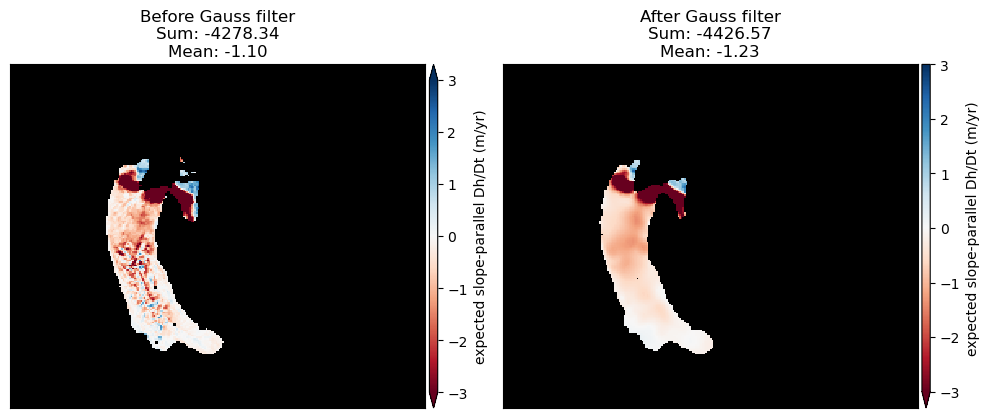

In [13]:
f,ax = plt.subplots(1,2,figsize=(10,5))
downslope_dhdt = velocity_timeseries.mask_by_shp(glac_shp.geometry,downslope_dhdt,ds=ds_list[1])
mean_init = np.round(downslope_dhdt.mean(),2)
mean_final = np.round(downslope_smooth.mean(),2)
sum_init = np.round(downslope_dhdt.sum(),2)
sum_final = np.round(downslope_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(downslope_dhdt,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='expected slope-parallel Dh/Dt (m/yr)')
pltlib.iv(downslope_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='expected slope-parallel Dh/Dt (m/yr)')
downslope_mean_list.append(mean_init)
downslope_sum_list.append(sum_init)
smooth_downslope_mean_list.append(mean_final)
smooth_downslope_sum_list.append(sum_final)
plt.tight_layout()

## Ngozumpa

In [14]:
%cd /nobackup/sbhusha1/chapter2/ngozumpa/20230217/

/nobackupp11/sbhusha1/chapter2/ngozumpa/20230217


In [15]:
div_q2_smooth_fn = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_divQ2.tif'
dem1_fn = '../20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_2m.tif'
downslope_smooth_fn = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_downslope_dhdt.tif' 
H_fn = constants.fetch_farinotti_thickness('ngozumpa')
vx_fn = '20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif'
vy_fn = '20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif'
ds_list = warplib.memwarp_multi_fn([div_q2_smooth_fn,H_fn,vx_fn,vy_fn,downslope_smooth_fn,dem1_fn])
div_q2_smooth,H,vx,vy,downslope_smooth,dem1 = [iolib.ds_getma(ds) for ds in ds_list]
glac_shp = gpd.read_file(constants.fetch_glac_shp(constants.rgi_dicts['ngozumpa'])).to_crs("EPSG:32645")


Warping all inputs to the following:
Resolution: 50.0
Extent: [466125.0, 3089925.0, 476775.0, 3104071.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 6: ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_divQ2.tif
nl: 283 ns: 213 res: 50.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 6: /nobackup/sbhusha1/hma/ngozumpa_lagdz/icethickness/RGI60-15/RGI60-15.03473_thickness.tif
nl: 283 ns: 213 res: 50.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 6: 20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif
nl: 283 ns: 213 res: 50.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 6: 20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kerne

In [16]:
res = geolib.get_res(ds_list[0])[0]
divq2 = glac_dyn.compute_simple_flux_div(vx,vy,H,dx=res,dy=res,smooth=False)
t1 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_farinotti_')[1].split('_to')[0])
t2 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_to_')[1].split('_divQ2')[0])
dt = timelib.get_t_factor(t1,t2)
downslope_dhdt = glac_dyn.compute_along_slope_flow_correction_working(dem1,vx,vy,dt=dt,smooth=False,origmask=True,res=res)

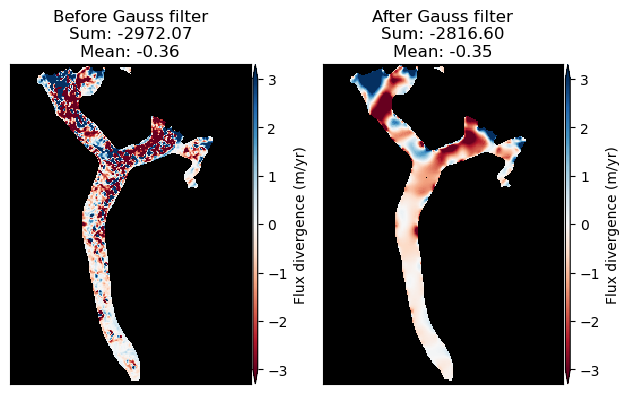

In [17]:
f,ax = plt.subplots(1,2)
mean_init = np.round(divq2.mean(),2)
mean_final = np.round(div_q2_smooth.mean(),2)
sum_init = np.round(divq2.sum(),2)
sum_final = np.round(div_q2_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(divq2,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='Flux divergence (m/yr)')
pltlib.iv(div_q2_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='Flux divergence (m/yr)')
divq2_mean_list.append(mean_init)
divq2_sum_list.append(sum_init)
smooth_divq2_mean_list.append(mean_final)
smooth_divq2_sum_list.append(sum_final)

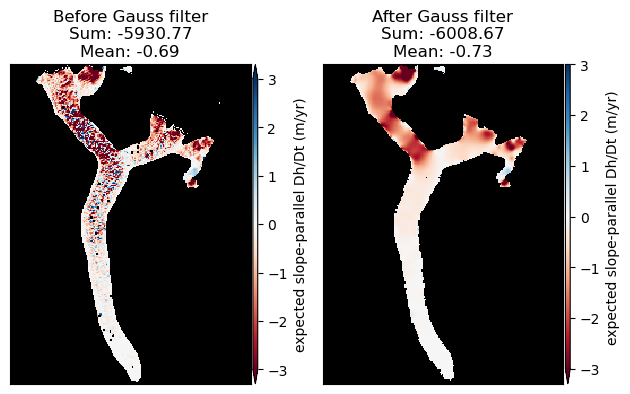

In [18]:
f,ax = plt.subplots(1,2)
downslope_dhdt = velocity_timeseries.mask_by_shp(glac_shp.geometry,downslope_dhdt,ds=ds_list[1])
mean_init = np.round(downslope_dhdt.mean(),2)
mean_final = np.round(downslope_smooth.mean(),2)
sum_init = np.round(downslope_dhdt.sum(),2)
sum_final = np.round(downslope_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(downslope_dhdt,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='expected slope-parallel Dh/Dt (m/yr)')
pltlib.iv(downslope_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='expected slope-parallel Dh/Dt (m/yr)')
downslope_mean_list.append(mean_init)
downslope_sum_list.append(sum_init)
smooth_downslope_mean_list.append(mean_final)
smooth_downslope_sum_list.append(sum_final)
plt.tight_layout()

## Langtang

In [19]:
%cd /nobackup/sbhusha1/chapter2/langtang/20230223/

/nobackupp11/sbhusha1/chapter2/langtang/20230223


In [20]:
div_q2_smooth_fn = 'langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_farinotti_2015-02-22_to_2016-01-07_divQ2.tif'
downslope_smooth_fn = 'langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_farinotti_2015-02-22_to_2016-01-07_downslope_dhdt.tif'
dem1_fn = '../20150222_aligned/20150222_aligned-trans_source-DEM.tif'
H_fn = constants.fetch_farinotti_thickness('langtang')
vx_fn = '20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif'
vy_fn = '20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif'
ds_list = warplib.memwarp_multi_fn([div_q2_smooth_fn,H_fn,vx_fn,vy_fn,downslope_smooth_fn,dem1_fn])
div_q2_smooth,H,vx,vy,downslope_smooth,dem1 = [iolib.ds_getma(ds) for ds in ds_list]
glac_shp = gpd.read_file(constants.fetch_glac_shp(constants.rgi_dicts['langtang'])).to_crs("EPSG:32645")


Warping all inputs to the following:
Resolution: 25.0
Extent: [368087.5, 3121737.5, 375912.5, 3139937.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 6: langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_farinotti_2015-02-22_to_2016-01-07_divQ2.tif
2 of 6: /nobackup/sbhusha1/hma/ngozumpa_lagdz/icethickness/RGI60-15/RGI60-15.04121_thickness.tif
nl: 728 ns: 313 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 6: 20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif
nl: 728 ns: 313 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 6: 20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_k

In [21]:
res = geolib.get_res(ds_list[0])[0]
divq2 = glac_dyn.compute_simple_flux_div(vx,vy,H,dx=res,dy=res,smooth=False)
t1 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_farinotti_')[1].split('_to')[0])
t2 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_to_')[1].split('_divQ2')[0])
dt = timelib.get_t_factor(t1,t2)
downslope_dhdt = glac_dyn.compute_along_slope_flow_correction_working(dem1,vx,vy,dt=dt,smooth=False,origmask=True,res=res)

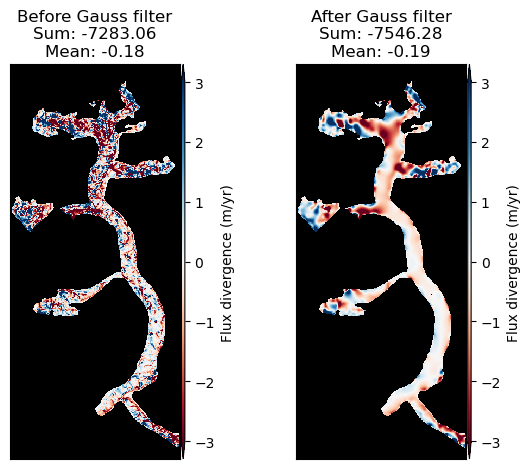

In [22]:
f,ax = plt.subplots(1,2)
mean_init = np.round(divq2.mean(),2)
mean_final = np.round(div_q2_smooth.mean(),2)
sum_init = np.round(divq2.sum(),2)
sum_final = np.round(div_q2_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(divq2,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='Flux divergence (m/yr)')
pltlib.iv(div_q2_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='Flux divergence (m/yr)')
divq2_mean_list.append(mean_init)
divq2_sum_list.append(sum_init)
smooth_divq2_mean_list.append(mean_final)
smooth_divq2_sum_list.append(sum_final)

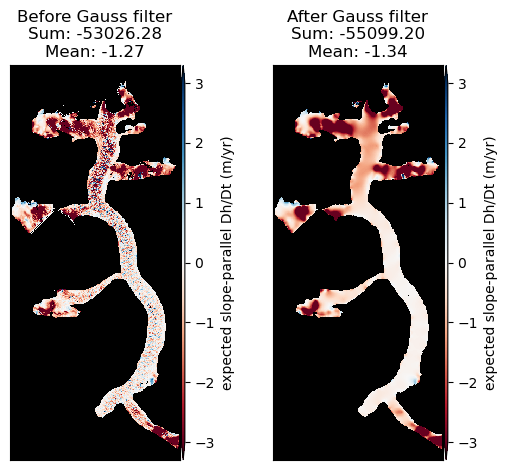

In [23]:
f,ax = plt.subplots(1,2)
downslope_dhdt = velocity_timeseries.mask_by_shp(glac_shp.geometry,downslope_dhdt,ds=ds_list[1])
mean_init = np.round(downslope_dhdt.mean(),2)
mean_final = np.round(downslope_smooth.mean(),2)
sum_init = np.round(downslope_dhdt.sum(),2)
sum_final = np.round(downslope_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(downslope_dhdt,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='expected slope-parallel Dh/Dt (m/yr)')
pltlib.iv(downslope_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='expected slope-parallel Dh/Dt (m/yr)')
downslope_mean_list.append(mean_init)
downslope_sum_list.append(sum_init)
smooth_downslope_mean_list.append(mean_final)
smooth_downslope_sum_list.append(sum_final)
plt.tight_layout()

## Imja Lhotse Shar

In [24]:
%cd /nobackup/sbhusha1/chapter2/imja/20230223/

/nobackupp11/sbhusha1/chapter2/imja/20230223


In [25]:
div_q2_smooth_fn = 'imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/imja_farinotti_2015-10-02_to_2016-10-29_divQ2.tif'
dem1_fn = '../20151002_0651_10200100457F0C00_1020010042C0CE00-DEM_2m.tif'
downslope_smooth_fn = 'imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/imja_farinotti_2015-10-02_to_2016-10-29_downslope_dhdt.tif'
H_fn = constants.fetch_farinotti_thickness('imja')
vx_fn = '20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif'
vy_fn = '20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif'
ds_list = warplib.memwarp_multi_fn([div_q2_smooth_fn,H_fn,vx_fn,vy_fn,downslope_smooth_fn,dem1_fn])
div_q2_smooth,H,vx,vy,downslope_smooth,dem1 = [iolib.ds_getma(ds) for ds in ds_list]
glac_shp = gpd.read_file(constants.fetch_glac_shp(constants.rgi_dicts['imja'])).to_crs("EPSG:32645")


Warping all inputs to the following:
Resolution: 25.0
Extent: [492962.5, 3084915.0, 498337.5, 3092462.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 6: imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/imja_farinotti_2015-10-02_to_2016-10-29_divQ2.tif
nl: 302 ns: 215 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 6: /nobackup/sbhusha1/hma/ngozumpa_lagdz/icethickness/RGI60-15/RGI60-15.03743_thickness.tif
nl: 302 ns: 215 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 6: 20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif
nl: 302 ns: 215 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 6: 20151002_combined_hs_masked__20161029_combined_hs_masked_

In [26]:
res = geolib.get_res(ds_list[0])[0]
divq2 = glac_dyn.compute_simple_flux_div(vx,vy,H,dx=res,dy=res,smooth=False)
t1 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_farinotti_')[1].split('_to')[0])
t2 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_to_')[1].split('_divQ2')[0])
dt = timelib.get_t_factor(t1,t2)
downslope_dhdt = glac_dyn.compute_along_slope_flow_correction_working(dem1,vx,vy,dt=dt,smooth=False,origmask=True,res=res)

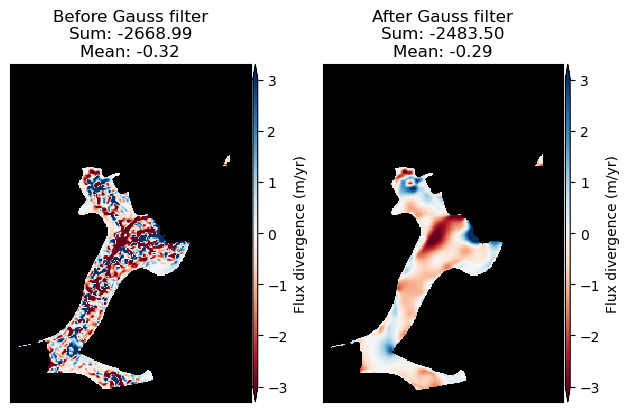

In [27]:
f,ax = plt.subplots(1,2)
mean_init = np.round(divq2.mean(),2)
mean_final = np.round(div_q2_smooth.mean(),2)
sum_init = np.round(divq2.sum(),2)
sum_final = np.round(div_q2_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(divq2,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='Flux divergence (m/yr)')
pltlib.iv(div_q2_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='Flux divergence (m/yr)')
divq2_mean_list.append(mean_init)
divq2_sum_list.append(sum_init)
smooth_divq2_mean_list.append(mean_final)
smooth_divq2_sum_list.append(sum_final)

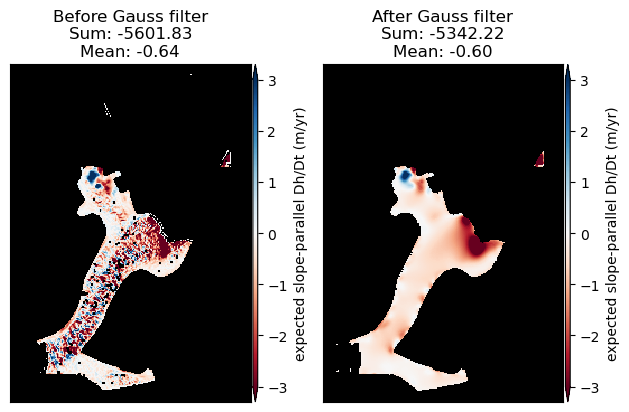

In [28]:
f,ax = plt.subplots(1,2)
downslope_dhdt = velocity_timeseries.mask_by_shp(glac_shp.geometry,downslope_dhdt,ds=ds_list[1])
mean_init = np.round(downslope_dhdt.mean(),2)
mean_final = np.round(downslope_smooth.mean(),2)
sum_init = np.round(downslope_dhdt.sum(),2)
sum_final = np.round(downslope_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(downslope_dhdt,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='expected slope-parallel Dh/Dt (m/yr)')
pltlib.iv(downslope_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='expected slope-parallel Dh/Dt (m/yr)')
downslope_mean_list.append(mean_init)
downslope_sum_list.append(sum_init)
smooth_downslope_mean_list.append(mean_final)
smooth_downslope_sum_list.append(sum_final)
plt.tight_layout()

## Lirung

In [29]:
%cd /nobackup/sbhusha1/chapter2/lirung/202320218/

/nobackupp11/sbhusha1/chapter2/lirung/202320218


In [30]:
div_q2_smooth_fn = 'lirung_farinotti_2016-11-06_to_2017-12-22_lag_smb_products/lirung_farinotti_2016-11-06_to_2017-12-22_divQ2.tif'
dem1_fn = '../20161106_0456_103001005FAB7A00_103001005F7EBB00-DEM_2m_align.tif'
downslope_smooth_fn = 'lirung_farinotti_2016-11-06_to_2017-12-22_lag_smb_products/lirung_farinotti_2016-11-06_to_2017-12-22_downslope_dhdt.tif'
H_fn = constants.fetch_farinotti_thickness('lirung')
vx_fn = '20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_1_masked_gauss_fill51px.tif'
vy_fn = '20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_1_masked_gauss_fill51px.tif'
ds_list = warplib.memwarp_multi_fn([div_q2_smooth_fn,H_fn,vx_fn,vy_fn,downslope_smooth_fn,dem1_fn])
div_q2_smooth,H,vx,vy,downslope_smooth,dem1 = [iolib.ds_getma(ds) for ds in ds_list]
glac_shp = gpd.read_file(constants.fetch_glac_shp(constants.rgi_dicts['lirung'])).to_crs("EPSG:32645")


Warping all inputs to the following:
Resolution: 25.0
Extent: [357337.5, 3122712.5, 359212.5, 3126237.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 6: lirung_farinotti_2016-11-06_to_2017-12-22_lag_smb_products/lirung_farinotti_2016-11-06_to_2017-12-22_divQ2.tif
2 of 6: /nobackup/sbhusha1/hma/ngozumpa_lagdz/icethickness/RGI60-15/RGI60-15.04045_thickness.tif
3 of 6: 20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_1_masked_gauss_fill51px.tif
nl: 141 ns: 75 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 6: 20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm/20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_1_masked_gauss_fill51px.tif
nl: 141 ns: 75 res: 25.000
100 

In [31]:
res = geolib.get_res(ds_list[0])[0]
divq2 = glac_dyn.compute_simple_flux_div(vx,vy,H,dx=res,dy=res,smooth=False)
t1 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_farinotti_')[1].split('_to')[0])
t2 = timelib.strptime_fuzzy(os.path.basename(div_q2_smooth_fn).split('_to_')[1].split('_divQ2')[0])
dt = timelib.get_t_factor(t1,t2)
downslope_dhdt = glac_dyn.compute_along_slope_flow_correction_working(dem1,vx,vy,dt=dt,smooth=False,origmask=True,res=res)

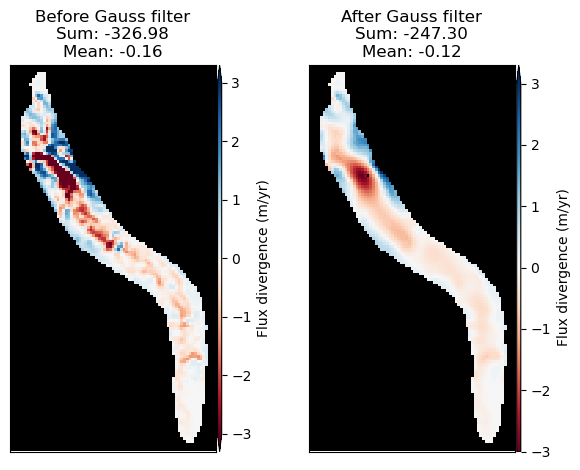

In [32]:
f,ax = plt.subplots(1,2)
mean_init = np.round(divq2.mean(),2)
mean_final = np.round(div_q2_smooth.mean(),2)
sum_init = np.round(divq2.sum(),2)
sum_final = np.round(div_q2_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(divq2,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='Flux divergence (m/yr)')
pltlib.iv(div_q2_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='Flux divergence (m/yr)')
divq2_mean_list.append(mean_init)
divq2_sum_list.append(sum_init)
smooth_divq2_mean_list.append(mean_final)
smooth_divq2_sum_list.append(sum_final)

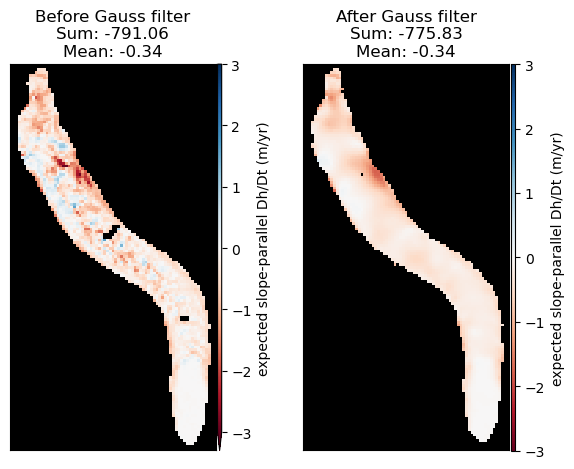

In [33]:
f,ax = plt.subplots(1,2)
downslope_dhdt = velocity_timeseries.mask_by_shp(glac_shp.geometry,downslope_dhdt,ds=ds_list[1])
mean_init = np.round(downslope_dhdt.mean(),2)
mean_final = np.round(downslope_smooth.mean(),2)
sum_init = np.round(downslope_dhdt.sum(),2)
sum_final = np.round(downslope_smooth.sum(),2)
title_init =f"Before Gauss filter\nSum: {sum_init:.2f}\nMean: {mean_init:.2f}"
title_final =f"After Gauss filter\nSum: {sum_final:.2f}\nMean: {mean_final:.2f}"
pltlib.iv(downslope_dhdt,ax=ax[0],cmap='RdBu',clim=(-3,3),title=title_init,label='expected slope-parallel Dh/Dt (m/yr)')
pltlib.iv(downslope_smooth,ax=ax[1],cmap='RdBu',clim=(-3,3),title=title_final,label='expected slope-parallel Dh/Dt (m/yr)')
downslope_mean_list.append(mean_init)
downslope_sum_list.append(sum_init)
smooth_downslope_mean_list.append(mean_final)
smooth_downslope_sum_list.append(sum_final)
plt.tight_layout()

## Combine sum and mean

In [34]:
glac_list = ['khumbu','black_changri_nup','ngozumpa','langtang','imja_lhotse_shar','lirung']
div_q2_stats = pd.DataFrame({'glacier':glac_list,'div_q2_sum':divq2_sum_list,'div_q2_fltr_sum':smooth_divq2_sum_list,'div_q2_mean':divq2_mean_list,'div_q2_fltr_mean':smooth_divq2_mean_list})

In [35]:
div_q2_stats

,glacier,div_q2_sum,div_q2_fltr_sum,div_q2_mean,div_q2_fltr_mean
0,khumbu,-8718.820312,-8253.41,-0.66,-0.62
1,black_changri_nup,-94.449997,-75.50,-0.03,-0.02
2,ngozumpa,-2972.070068,-2816.60,-0.36,-0.35
3,langtang,-7283.060059,-7546.28,-0.18,-0.19
4,imja_lhotse_shar,-2668.989990,-2483.50,-0.32,-0.29
5,lirung,-326.980011,-247.30,-0.16,-0.12


In [36]:
glac_list = ['khumbu','black_changri_nup','ngozumpa','langtang','imja_lhotse_shar','lirung']
slope_parallel_DhDt_stats = pd.DataFrame({'glacier':glac_list,'slope_parallel_DhDt_sum':downslope_sum_list,
                                          'slope_parallel_DhDt_fltr_sum':smooth_downslope_sum_list,'slope_parallel_DhDt_mean':downslope_mean_list,'slope_parallel_DhDt_fltr_mean':smooth_downslope_mean_list})

In [37]:
slope_parallel_DhDt_stats

,glacier,slope_parallel_DhDt_sum,slope_parallel_DhDt_fltr_sum,slope_parallel_DhDt_mean,slope_parallel_DhDt_fltr_mean
0,khumbu,-13831.379883,-13469.04,-0.99,-0.98
1,black_changri_nup,-4278.339844,-4426.57,-1.10,-1.23
2,ngozumpa,-5930.770020,-6008.67,-0.69,-0.73
3,langtang,-53026.281250,-55099.20,-1.27,-1.34
4,imja_lhotse_shar,-5601.830078,-5342.22,-0.64,-0.60
5,lirung,-791.059998,-775.83,-0.34,-0.34
